In [1]:
import os
import sys 
import logging
import numpy as np
import torch as th
from matplotlib import pyplot as plt
from model import *
from utility import *
from aigle import aigle
th.set_default_tensor_type(th.FloatTensor)
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1.5
cmap = plt.get_cmap('viridis')
new_cmap = truncate_colormap(cmap, 0.4, 1)

################## AIGLE parameters  ##################
base_params = {
    # "comments": "CV:dipole; Int: 2rd nn: Jtanh(wx); Onsite:4-th poly+tanh**2, fix E=born-derived;retrain GAR,  E=0 eq-train;  E=2.0 noneq-train; direct-loss; no group-loss; noise include 2rdnn; impose simple 2fdt",#!
    "comments"   : "CV:dipole; Int: 2rd nn; Onsite:4-th poly, free E;retrain GAR,  E=0 eq-train;  E=random noneq-train; direct-loss; boundary-loss; GAR no bias, noise include 2rdnn; impose simple 2fdt", 
    ## data params
    "efield"     :0.5,
    "temp"       : 300,
    "md_dt"      : 0.002,
    "stride"     : 5,
    "smooth"     : 40,
    "block"      : 1,
    "nskip"      : 2,
    "relax_t"    : 1,       # the relaxation time from the constrained structure
    "window_x"   : 10,    # window size for training: x,y,z 
    "window_y"   : 10,    # window size for training: x,y,z 
    "window_z"   : 8,     # window size for training: x,y,z 
    "max_frames" : 2000, # maximal frames used for one batch
    ## model params 
    "onsite_only": True,
    "len_ag"     : 50,
    "lmem"       : 150,
    ## loading params
    "load"       : True,
    "base_folder": "./g5s40b1ag50lmem150T300",
    "load_stage"  : "stage2",
    "load_label" : "10000",
    ## logging params
    "print_freq" : 1000,
    "save_freq"  : 1000,
    "profile"    : False,
    "debug"      : False,
    "langevin"   : 0,
}
base_params["dt"] = base_params["md_dt"] * base_params["stride"]
base_params["load_path"] = os.path.join( base_params['base_folder'], base_params['load_stage'])


In [2]:
################## Initialize working folders and logs    ##################
base_params["out_folder"] =  os.path.join( base_params['base_folder'], 'Simulation')
assert os.path.exists(base_params["load_path"]) 
print('Base folder:', base_params["base_folder"])
if os.path.exists(base_params["out_folder"]) is False:
    os.mkdir(base_params["out_folder"])
logging.basicConfig(filename=os.path.join(base_params["out_folder"], 'simulation.log'),  level=logging.INFO)

################## model initialization    ##################
model_ext = poly_3Dsystem(lmem=base_params["lmem"],  onsite_only=base_params["onsite_only"] )
model_noise = FNN_noise_nnn( in_channels=base_params["len_ag"], onsite_only=base_params["onsite_only"] ) 
aigle_3d = aigle( base_params["temp"], dt=base_params["dt"], len_ag=base_params["len_ag"], lmem=base_params["lmem"], nskip=base_params["nskip"], 
        model_ext = model_ext, model_noise = model_noise  )
aigle_3d.load_model(base_params["load_path"], label=base_params["load_label"])



Base folder: ./g5s40b1ag50lmem150T300


## Simulate domain relaxation with AIGLE and AILE

In [3]:
################## Use a few frames of MD trajectory as initial configuration   ##################
trainset = []
folder = './md_data/50X50X12T{}E{:.2f}'.format( base_params["temp"],base_params["efield"])
traj = np.load(os.path.join(folder, 'dipole.npy'))
r,v,a = read_out_smooth( 
    traj, stride=base_params['stride'], le_dt=base_params['dt'], smooth = base_params['smooth'], 
    throw=int(base_params['relax_t'] / base_params['md_dt']), 
    block=base_params['block'])
del traj
trainset.append(
        {'r':r, 'v':v, 'a':a, 'e': np.zeros_like(r)+base_params['efield'],}  
        )
aigle_3d.v2_avg = (v**2).mean((0,1,2,4))


total_time = 100

### simulate domain relaxation with AIGLE
traj_gle, traj_md = aigle_3d.compute_trajectory( trainset, base_params, 
    replicate=1, nbatch = 1, total_time=total_time, setidx = 0)  # (nframes, nbatch  )

### simulate domain relaxation with LE
base_params['langevin'] = 1
traj_le, traj_md = aigle_3d.compute_trajectory( trainset, base_params, 
    replicate=1, nbatch = 1, total_time=total_time, setidx = 0)  # (nframes, nbatch   )

### Load MD domain relaxation trajectory
traj = np.load(os.path.join(folder, 'dipole_200ps.npy'))
traj_md = traj[5:,:,:,:,2]
print('md data initial Pz:',traj_md[0].mean())
print('gle data initial Pz:',traj_gle[0].mean())


reference attached: step=0
step:0
reference attached: step=100
step:100
reference attached: step=200
step:200
reference attached: step=300
step:300
reference attached: step=400
step:400
reference attached: step=500
step:500
reference attached: step=600
step:600
reference attached: step=700
step:700
reference attached: step=800
step:800
reference attached: step=900
step:900
reference attached: step=1000
step:1000
reference attached: step=1100
step:1100
reference attached: step=1200
step:1200
reference attached: step=1300
step:1300
reference attached: step=1400
step:1400
step:1500
step:1600
step:1700
step:1800
step:1900
step:2000
step:2100
step:2200
step:2300
step:2400
step:2500
step:2600
step:2700
step:2800
step:2900
step:3000
step:3100
step:3200
step:3300
step:3400
step:3500
step:3600
step:3700
step:3800
step:3900
step:4000
step:4100
step:4200
step:4300
step:4400
step:4500
step:4600
step:4700
step:4800
step:4900
step:5000
step:5100
step:5200
step:5300
step:5400
step:5500
step:5600
step

## plot snapshots

nsim =99, n_ref = 196


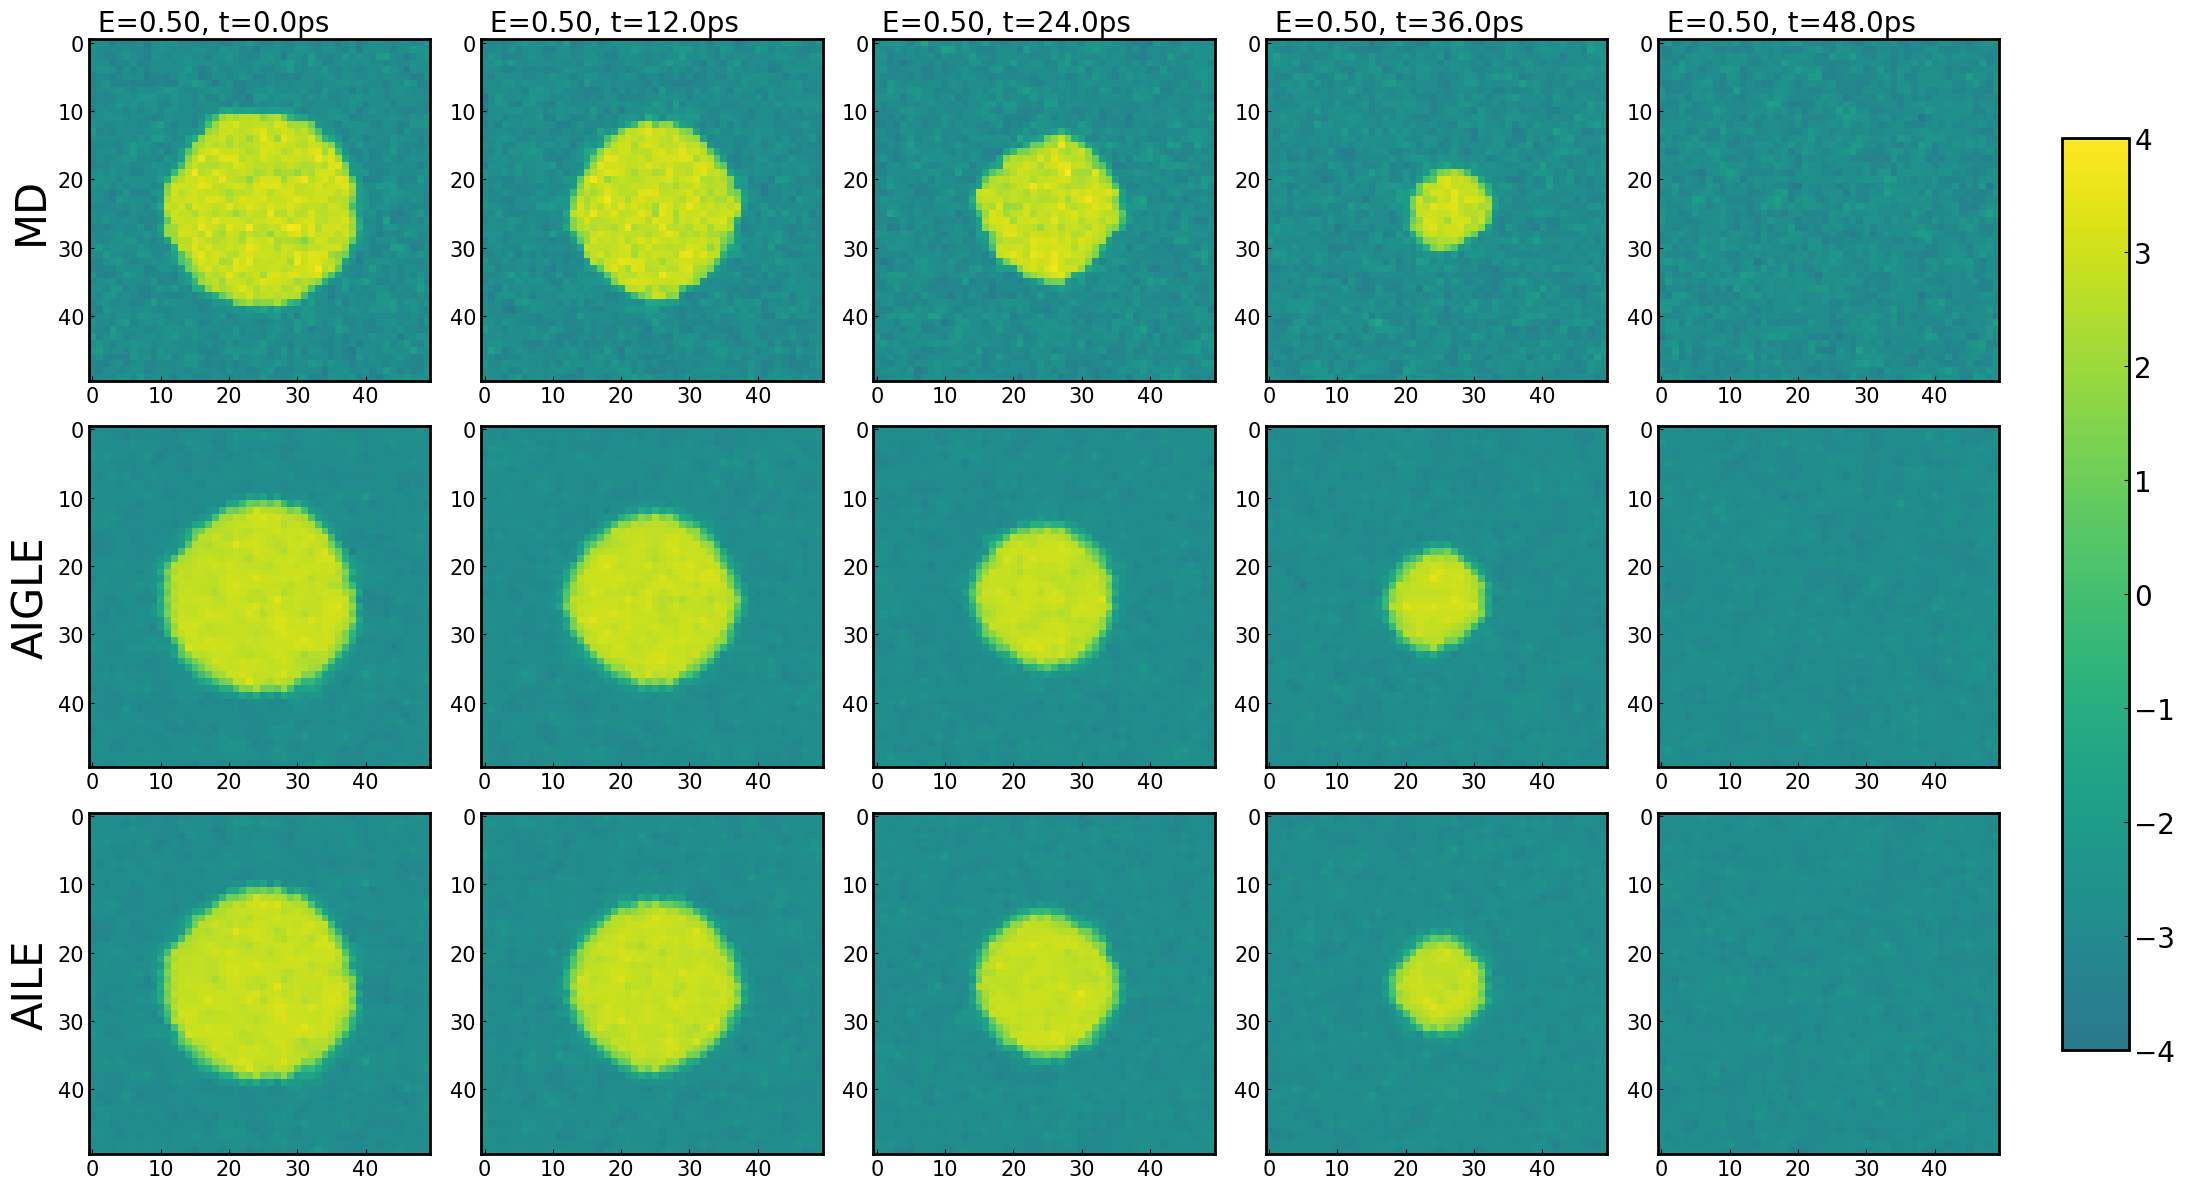

In [4]:
n_sim, nx, ny, nz = traj_gle.shape
n_ref = traj_md.shape[0]
print('nsim ={}, n_ref = {}'.format(n_sim, n_ref))
# cb =1- checkerboard((nx,ny))
cb =checkerboard((nx,ny)).astype(bool)

if base_params['efield'] == 0.5:
    time_slot = np.array([0,1,2,3,4])*12
elif base_params['efield'] == 1.0:
    time_slot = np.array([0,1,2,3,4])*30 
fig_traj, ax_traj = plt.subplots( 3,len(time_slot), figsize = (4.5*len(time_slot), 12) )

dt = base_params["dt"] * 100
for ii, tt in enumerate(time_slot):
    ## plot MD snapshot
    xx = traj_md[tt][:,:,nz//2].transpose()
    im = ax_traj[0,ii].imshow(xx,vmin=-4, vmax=4, cmap=new_cmap )   #(nx,ny,nz,3,nbatch, nframes)
    ## plot AIGLE snapshot
    xx = traj_gle[tt][:,:,nz//2].transpose()
    xx[cb] *= 0
    xx += np.roll(xx,1,0)+np.roll(xx,-1,0)+np.roll(xx,1,1)+np.roll(xx,-1,1)
    xx[cb] /= 4
    im = ax_traj[1,ii].imshow( xx,vmin=-4, vmax=4, cmap=new_cmap  )   #(nx,ny,nz,3,nbatch, nframes)
    ## plot AILE snapshot
    xx = traj_le[tt][:,:,nz//2].transpose()
    xx[cb] *= 0
    xx += np.roll(xx,1,0)+np.roll(xx,-1,0)+np.roll(xx,1,1)+np.roll(xx,-1,1)
    xx[cb] /= 4
    im = ax_traj[2,ii].imshow( xx,vmin=-4, vmax=4, cmap=new_cmap  )   #(nx,ny,nz,3,nbatch, nframes)
    
    ax_traj[0,ii].set_title(' E={:.2f}, t={:.1f}ps '.format(base_params['efield'], tt*dt),loc='left', fontsize=20)
ax_traj[0,0].set_ylabel('MD', fontsize=30)
ax_traj[1,0].set_ylabel('AIGLE', fontsize=30)
ax_traj[2,0].set_ylabel('AILE', fontsize=30)

plt.tight_layout()
plt.subplots_adjust( right=0.90,  )
cax = plt.axes([0.92, 0.12, 0.03, 0.76])
cb = fig_traj.colorbar(im, cax=cax)
cax.tick_params(axis="both", labelsize=20)
